# Set up

In [ ]:
!pip install -U sentence-transformers
!pip install faiss-cpu
!pip install transformers sentencepiece
!pip install langchain langchain-community
!pip install nltk rouge-score
!pip install openai
!pip install ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58

In [ ]:
! rm -r /content/sample_data

In [ ]:
!git clone https://github.com/georgepan900530/SkillSync-AI-Enhanced-Job-Matching-and-Conversational-Search.git

Cloning into 'SkillSync-AI-Enhanced-Job-Matching-and-Conversational-Search'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 46 (delta 1), reused 17 (delta 1), pack-reused 28 (from 1)
Receiving objects: 100% (46/46), 34.83 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
%cd SkillSync-AI-Enhanced-Job-Matching-and-Conversational-Search

/content/SkillSync-AI-Enhanced-Job-Matching-and-Conversational-Search


In [ ]:
!nvidia-smi

Wed Oct  9 11:11:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Phase 1: Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize
import faiss
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
import spacy
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
import time
from torch.utils.data import DataLoader

In [ ]:
# Read data
df_train = pd.read_csv('./data/train-1.csv')
df_test = pd.read_csv('./data/test-1.csv')
additional_jobs = pd.read_csv('./data/jobs.csv')
additional_jobs = additional_jobs.drop_duplicates(subset=["description"]).reset_index(drop=True)
additional_jobs = additional_jobs.rename(columns={"job_name": "Job-Title", "location": "Location", "description": "Description"})
additional_jobs = additional_jobs[["Job-Title", "Location", "Description"]]
df_train = pd.concat([df_train, additional_jobs], ignore_index=True)
# Remove duplicates and reset index for training data
df_train = df_train.drop_duplicates().reset_index(drop=True)

# Remove duplicates and reset index for test data
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [ ]:
# Assign 'Job_ID' to df_train
df_train = df_train.reset_index().rename(columns={'index': 'Job_ID'})
df_train['Job_ID'] = df_train['Job_ID'].astype(int)

# Assign 'Job_ID' to df_test
df_test = df_test.reset_index().rename(columns={'index': 'Job_ID'})
df_test['Job_ID'] = df_test['Job_ID'].astype(int)

In [ ]:
# Fill missing salary values
df_train['Salary'].fillna('Unknown', inplace=True)
df_test['Salary'].fillna('Unknown', inplace=True)

# Remove special characters from 'Description'
df_train['Description'] = df_train['Description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_test['Description'] = df_test['Description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Convert text to lowercase
df_train['Resume'] = df_train['Resume'].str.lower()
df_train['Job-Title'] = df_train['Job-Title'].str.lower()
df_test['Resume'] = df_test['Resume'].str.lower()
df_test['Job-Title'] = df_test['Job-Title'].str.lower()

<ipython-input-9-1114491e6279>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Salary'].fillna('Unknown', inplace=True)
<ipython-input-9-1114491e6279>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
# Correct specific locations
location_corrections = {
    "Calgary, AB": "Calgary, AB, Canada",
    "Edmonton, AB": "Edmonton, AB, Canada",
    "Vancouver, BC": "Vancouver, BC, Canada",
    "Texas, USA": "Texas, TX, USA"
}

df_train['Location'] = df_train['Location'].replace(location_corrections)
df_test['Location'] = df_test['Location'].replace(location_corrections)

In [ ]:
# Example exchange rates
exchange_rates = {
    '₹': 0.012,  # INR to USD
    '€': 1.1,    # EUR to USD
    '£': 1.3,    # GBP to USD
    '$': 1.0,    # USD to USD (for simplicity)
    'AUD': 0.65,  # AUD to USD
    # Add more currencies as needed
}

In [ ]:
# Function to clean salary data and extract minimum salary
def clean_salary(salary):
    if pd.isna(salary):
        return None  # Handle NaN values

    # Regex pattern to match currency symbols and salary
    pattern = r'(\D*)([\d.]+)([kM]?)\s*[-–]?\s*([\d.]+)?([kM]?)'  # Match salary with optional k/M
    match = re.search(pattern, salary)

    if match:
        currency = match.group(1).strip()  # Currency symbol or letters
        min_salary = match.group(2)  # First salary (min)
        min_suffix = match.group(3)  # Suffix for min (k/M)

        # Convert the amount to float, handling 'k' and 'M'
        def convert_to_float(amount, suffix):
            if suffix == 'M':
                return float(amount) * 1_000_000
            elif suffix == 'k':
                return float(amount) * 1_000
            else:
                return float(amount)

        try:
            min_salary = convert_to_float(min_salary, min_suffix)
            # Return the parsed currency and min_salary
            return currency, min_salary
        except ValueError:
            return None

    return None

# Function to convert minimum salary to USD
def convert_min_salary_to_usd(salary_tuple):
    if salary_tuple is None:
        return None  # Handle None values

    currency, min_salary = salary_tuple
    conversion_rate = exchange_rates.get(currency, None)

    if conversion_rate is not None:
        min_salary_usd = min_salary * conversion_rate
        return min_salary_usd
    return None  # If currency not found

# Apply the clean_salary function to the 'Salary' column
df_train['Salary_clean'] = df_train['Salary'].apply(clean_salary)
df_test['Salary_clean'] = df_test['Salary'].apply(clean_salary)
df_train['Min_Salary_USD'] = df_train['Salary_clean'].apply(convert_min_salary_to_usd)
df_test['Min_Salary_USD'] = df_test['Salary_clean'].apply(convert_min_salary_to_usd)

# Drop intermediate salary columns
df_train.drop(['Salary', 'Salary_clean'], axis=1, inplace=True)
df_test.drop(['Salary', 'Salary_clean'], axis=1, inplace=True)

# Handle missing salary data
# Fill missing salary with minimum salary: https://www.monster.com/career-advice/article/state-minimum-wage#
df_train['Min_Salary_USD'] = df_train['Min_Salary_USD'].fillna(15080)
df_test['Min_Salary_USD'] = df_test['Min_Salary_USD'].fillna(15080)

In [ ]:
df_train['Full-Job-Description'] = (
    df_train['Job-Title'] + ' ' +
    df_train['Description'] + ' ' +
    df_train['Location'] + ' ' +
    'Minimum Salary: ' + df_train['Min_Salary_USD'].astype(str)
)

df_test['Full-Job-Description'] = (
    df_test['Job-Title'] + ' ' +
    df_test['Description'] + ' ' +
    df_test['Location'] + ' ' +
    'Minimum Salary: ' + df_test['Min_Salary_USD'].astype(str)
)

## Fixed-Size Chunking

In [ ]:
# Define the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", "", ".", "!", "?", ","],
    chunk_size=500,
    chunk_overlap=50
)

In [ ]:
def split_into_chunks(text):
    return text_splitter.split_text(text)

df_train["job-chunks"] = df_train["Full-Job-Description"].apply(split_into_chunks)
df_test["job-chunks"] = df_test["Full-Job-Description"].apply(split_into_chunks)

## Semantic Chunking

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModel

nltk.download('punkt')

def semantic_chunk_text(text, tokenizer, max_tokens=250):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        # Tokenize the sentence
        tokens = tokenizer.tokenize(sentence)
        token_count = len(tokens)

        # Handle sentences longer than max_tokens
        if token_count > max_tokens:
            # Split the sentence into smaller parts
            words = sentence.split()
            sub_sentence = ''
            for word in words:
                word_tokens = tokenizer.tokenize(word)
                if len(word_tokens) + current_length > max_tokens:
                    if sub_sentence:
                        chunks.append(sub_sentence.strip())
                    sub_sentence = word
                    current_length = len(word_tokens)
                else:
                    sub_sentence += ' ' + word
                    current_length += len(word_tokens)
            if sub_sentence:
                chunks.append(sub_sentence.strip())
            current_length = 0
            continue

        # If adding the sentence exceeds max_tokens, start a new chunk
        if current_length + token_count > max_tokens:
            if current_chunk:
                chunks.append(' '.join(current_chunk).strip())
            current_chunk = [sentence]
            current_length = token_count
        else:
            current_chunk.append(sentence)
            current_length += token_count

    # Add the last chunk
    if current_chunk:
        chunks.append(' '.join(current_chunk).strip())

    return chunks


# Apply to 'Full-Job-Description' in df_train
df_train["job_chunks_semantic"] = df_train["Full-Job-Description"].apply(lambda x: semantic_chunk_text(x, tokenizer))

# Apply to 'Full-Job-Description' in df_test
df_test["job_chunks_semantic"] = df_test["Full-Job-Description"].apply(lambda x: semantic_chunk_text(x, tokenizer))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors


## Generate Embeddings

In [ ]:
model = model.to('cuda')

### Normal Embedding

In [ ]:
def get_embedding(text):
    # Check if the input is a valid non-empty string
    if not isinstance(text, str) or not text.strip():
        # Return a zero vector as a placeholder
        return np.zeros(model.config.hidden_size)

    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding='max_length'
    ).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)
        # Use mean pooling of the last hidden state
        embedding = outputs.last_hidden_state.mean(dim=1)

    return embedding.squeeze().cpu().numpy()

In [ ]:
# Generate embeddings for job-description
# Flatten the chunks and create a mapping to the original job index
train_job_chunk_embeddings = []
train_job_chunk_ids = []  # Mapping from chunk index to job index

for idx, chunks in tqdm(enumerate(df_train['job-chunks']), desc='Train Embedding Job Chunks', total=len(df_train)):
    for chunk in chunks:
        embedding = get_embedding(chunk)
        train_job_chunk_embeddings.append(embedding)
        train_job_chunk_ids.append(idx)  # Store the job index for each chunk

# Generate embeddings for job descriptions
test_job_chunk_embeddings = []
test_job_chunk_ids = []

for idx, chunks in tqdm(enumerate(df_test['job-chunks']), desc='Test Embedding Job Chunks', total=len(df_test)):
    for chunk in chunks:
        embedding = get_embedding(chunk)
        test_job_chunk_embeddings.append(embedding)
        test_job_chunk_ids.append(idx)  # Store the job index for each chunk

Train Embedding Job Chunks:   0%|          | 0/1716 [00:00<?, ?it/s]

Test Embedding Job Chunks:   0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
train_job_chunk_embeddings = np.vstack(train_job_chunk_embeddings)
test_job_chunk_embeddings = np.vstack(test_job_chunk_embeddings)

In [ ]:
# Embedding for resume
train_resume_embeddings = []
for resume in tqdm(df_train['Resume'], desc='Train Embedding Resume'):
    embedding = get_embedding(resume)
    train_resume_embeddings.append(embedding)

test_resume_embeddings = []
for resume in tqdm(df_test['Resume'], desc='Test Embedding Resume'):
    embedding = get_embedding(resume)
    test_resume_embeddings.append(embedding)

train_resume_embeddings = np.vstack(train_resume_embeddings)
test_resume_embeddings = np.vstack(test_resume_embeddings)

Train Embedding Resume:   0%|          | 0/1716 [00:00<?, ?it/s]

Test Embedding Resume:   0%|          | 0/122 [00:00<?, ?it/s]

### Batch Embedding - Faster

In [ ]:
# Define a custom dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to generate embeddings in batches
def get_embeddings_in_batches(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc='Generating Embeddings'):
        batch_texts = texts[i:i+batch_size]
        # Create a mask for valid texts
        valid_mask = [isinstance(text, str) and text.strip() for text in batch_texts]
        valid_texts = [text if valid else '' for text, valid in zip(batch_texts, valid_mask)]
        # Tokenize the batch
        inputs = tokenizer(
            valid_texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        ).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            batch_embeddings = batch_embeddings.cpu().numpy()
        # Set embeddings for invalid texts to zero vectors
        for idx, valid in enumerate(valid_mask):
            if not valid:
                batch_embeddings[idx] = np.zeros(model.config.hidden_size)
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

def get_embeddings_in_batches_df(df, text_column, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc=f'Generating Embeddings for {text_column}'):
        batch_df = df.iloc[i:i+batch_size]
        batch_texts = batch_df[text_column].tolist()
        # Create a mask for valid texts
        valid_mask = [isinstance(text, str) and text.strip() for text in batch_texts]
        valid_texts = [text if valid else '' for text, valid in zip(batch_texts, valid_mask)]
        # Tokenize the batch
        inputs = tokenizer(
            valid_texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        ).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            batch_embeddings = batch_embeddings.cpu().numpy()
        # Set embeddings for invalid texts to zero vectors
        for idx, valid in enumerate(valid_mask):
            if not valid:
                batch_embeddings[idx] = np.zeros(model.config.hidden_size)
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [ ]:
# For training job chunks
train_job_texts = []
train_job_chunk_ids = []

for idx in range(len(df_train)):
    job_id = df_train.iloc[idx]['Job_ID']
    chunks = df_train.iloc[idx]['job-chunks']
    if isinstance(chunks, list) and chunks:
        for chunk in chunks:
            train_job_texts.append(chunk)
            train_job_chunk_ids.append(job_id)
    else:
        # Handle missing chunks if necessary
        pass

train_job_chunk_embeddings = get_embeddings_in_batches(train_job_texts, batch_size=32)

# For test job chunks
test_job_texts = []
test_job_chunk_ids = []

for idx in range(len(df_test)):
    job_id = df_test.iloc[idx]['Job_ID']
    chunks = df_test.iloc[idx]['job-chunks']
    if isinstance(chunks, list) and chunks:
        for chunk in chunks:
            test_job_texts.append(chunk)
            test_job_chunk_ids.append(job_id)
    else:
        # Handle missing chunks if necessary
        pass

test_job_chunk_embeddings = get_embeddings_in_batches(test_job_texts, batch_size=32)

Generating Embeddings:   0%|          | 0/371 [00:00<?, ?it/s]

Generating Embeddings:   0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
train_resume_embeddings = get_embeddings_in_batches_df(df_train, 'Resume', batch_size=32)
test_resume_embeddings = get_embeddings_in_batches_df(df_test, 'Resume', batch_size=32)

Generating Embeddings for Resume:   0%|          | 0/54 [00:00<?, ?it/s]

Generating Embeddings for Resume:   0%|          | 0/4 [00:00<?, ?it/s]

### Load the pre-embedded embeddings

In [ ]:
train_job_chunk_embeddings = np.load('./data/train_job_chunk_embeddings-1.npy')
train_resume_embeddings = np.load('./data/train_resume_embeddings-1.npy')
test_job_chunk_embeddings = np.load('./data/test_job_chunk_embeddings-1.npy')
test_resume_embeddings = np.load('./data/test_resume_embeddings-1.npy')

In [ ]:
# Normalize embeddings
train_job_chunk_embeddings_normalized = normalize(train_job_chunk_embeddings)
test_job_chunk_embeddings_normalized = normalize(test_job_chunk_embeddings)
train_resume_embeddings_normalized = normalize(train_resume_embeddings)
test_resume_embeddings_normalized = normalize(test_resume_embeddings)
#all_job_chunk_embeddings_normalized = normalize(all_job_chunk_embeddings)

# Phase 2: RAG

In [ ]:
embedding_dim = train_job_chunk_embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(embedding_dim)
index.add(train_job_chunk_embeddings_normalized.astype('float32'))

# Check how many vectors (job embeddings) are in the index
print("Number of job vectors in the index:", index.ntotal)

Number of job vectors in the index: 11844


In [ ]:
def retrieve_jobs(resume_embedding, top_n=5):
    # Ensure the embedding is normalized (if not already)
    resume_embedding_normalized = resume_embedding.reshape(1, -1)
    # If embeddings are not normalized, uncomment the next line
    # resume_embedding_normalized = normalize(resume_embedding_normalized)

    # Define a multiplier to retrieve more candidates initially
    initial_multiplier = 10  # You can adjust this value as needed

    # Perform the FAISS index search to retrieve more candidates
    distances, indices = index.search(resume_embedding_normalized.astype('float32'), top_n * initial_multiplier)

    # Map chunk indices to Job_IDs
    chunk_indices = indices[0]
    scores = distances[0]
    job_ids = [train_job_chunk_ids[idx] for idx in chunk_indices]

    # Build a DataFrame of job_ids and scores
    results_df = pd.DataFrame({
        'Job_ID': job_ids,
        'similarity_score': scores
    })

    # Aggregate the highest similarity score for each Job_ID
    job_scores_df = results_df.groupby('Job_ID', as_index=False)['similarity_score'].max()

    # Retrieve job details from df_train
    jobs_df = df_train[df_train['Job_ID'].isin(job_scores_df['Job_ID'])].copy()

    # Merge the job_scores_df with jobs_df to include the similarity scores
    jobs_with_scores = pd.merge(job_scores_df, jobs_df, on='Job_ID')

    # Remove duplicates based on 'Description'
    jobs_with_scores = jobs_with_scores.drop_duplicates(subset='Description')

    # Sort jobs by similarity score in descending order
    jobs_with_scores = jobs_with_scores.sort_values(by='similarity_score', ascending=False)

    # Select the top N unique jobs
    top_jobs = jobs_with_scores.head(top_n)

    # Reset index if needed
    top_jobs = top_jobs.reset_index(drop=True)

    return top_jobs

# Retrieve jobs for the first resume in the test set
resume_embedding = test_resume_embeddings_normalized[0]
retrieved_jobs = retrieve_jobs(resume_embedding, top_n=5)

# Display results
for i, (_, job) in enumerate(retrieved_jobs.iterrows()):
    print(f"Rank {i+1}:")
    print(f"Job Title: {job['Job-Title']}")
    print(f"Similarity Score: {job['similarity_score']:.4f}")
    print(f"Location: {job['Location']}")
    print(f"Salary: {job['Min_Salary_USD']}")
    print("Description:")
    print(job['Description'])
    print("---------")

Rank 1:
Job Title: frontend lead (reactjs, javascript)
Similarity Score: 0.9404
Location: ILA building, 146 Nguyen Dinh Chieu, Ward 6, District 3, HCMc, District 3, Ho Chi Minh
Salary: 15080.0
Description:
Collaborate with crossfunctional teams to define design and ship new features


Write welldesigned testable efficient code by using best software development practices


Participate in troubleshooting applicationrelated issues and maintaining high performance and device compatibility


Research and adopt new technologies to improve user experience


Architecturesystem design code review


Cooperate with product managers and business teams


Train and mentor junior members










Firm grasp of the JavaScript language including ES6 syntax bonus for TypeScript


Ability to write effective clean code


Have knowledge about ReactJS bonus for Tailwind andor CSS Modules









Spirit




Embraced engineering culture and agile development


Accept failures learn from it and move extreme

# LLM

In [ ]:
def generate_query_from_resume(resume_text):
    """
    Generates a query from the entire resume text.
    """
    # In this case, the query is just the resume text itself
    query = resume_text.strip()  # Removing leading/trailing whitespace
    return query

# Example usage with the first resume in your test dataframe
resume_text = df_test['Resume'].iloc[0]
query = generate_query_from_resume(resume_text)
print(query)

dynamic frontend developer with a passion for building modern and user-friendly interfaces. proficient in html5, css3, and javascript, with expertise in frameworks like react.js and angular. skilled in building responsive and accessible web applications. led projects such as redesigning user interfaces for e-commerce platforms using react.js and styled-components, and implementing client-side form validation and error handling using formik and yup. also contributed to projects including integrating internationalization and localization features for multi-language support, and optimizing website loading speed through performance profiling and caching strategies. actively participating in frontend communities and contributing to open-source projects to support the developer community.


In [ ]:
def embed_resume(resume_text):
    """
    Converts the resume text into an embedding using a SentenceTransformer model.
    """
    resume_embedding = model.encode(resume_text, convert_to_tensor=True)
    return resume_embedding

# Throw in your API key from OpenAI. I put $5 into mine which gives you a massive amount of tokens.


In [ ]:
from langchain.chat_models import ChatOpenAI

# Initialize the GPT-3.5-turbo model using your OpenAI API key
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0,
    openai_api_key="Your OpenAI API Key"

# Create a prompt to send to the LLM
def create_llm_prompt(resume_text, retrieved_jobs):
    """
    Creates a prompt to send to the GPT-3.5 model, combining the resume text and the retrieved jobs.
    """
    prompt = f"Using the following resume, generate the top 5 job matches:\n\nResume:\n{resume_text}\n\nRetrieved Jobs:\n"

    for i, job in retrieved_jobs.iterrows():
        prompt += f"Job {i+1}:\n"
        prompt += f"Title: {job['Job-Title']}\n"
        prompt += f"Description: {job['Description']}\n"
        prompt += f"Location: {job['Location']}\n"
        prompt += f"Similarity Score: {job['similarity_score']}\n"
        prompt += "----------\n"

    return prompt

llm_prompt = create_llm_prompt(resume_text, retrieved_jobs)

# Send the prompt to the OpenAI GPT-3.5 model
response = llm.invoke(llm_prompt)

# Display the response content
print(response.content)

<ipython-input-36-9a7e8503954a>:4: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(


Top 5 job matches for the frontend developer with expertise in React.js and Angular:

1. Frontend Lead (React.js, JavaScript) - Similarity Score: 0.9403566718101501
2. Frontend Developer (React.js) - Similarity Score: 0.9400207996368408
3. Flutter/Dart/React Native Developer - Similarity Score: 0.9399465322494507
4. PHP Tech Lead (Laravel/Symfony) - Similarity Score: 0.9372632503509521
5. Frontend Developer (React.js/Vue.js/Angular) - Similarity Score: 0.9372574687004089


# Phase 3: Evaluation Using Ares

# Context Relevance

In [ ]:
# Define a list of common skills
common_skills = [
    'python', 'java', 'c++', 'sql', 'machine learning', 'data analysis',
    'communication', 'project management', 'teamwork', 'problem-solving',
]

# Function to extract skills from text
def extract_skills(text):
    skills_found = []
    text = text.lower()
    for skill in common_skills:
        if skill.lower() in text:
            skills_found.append(skill.lower())
    return list(set(skills_found))  # Remove duplicates

In [ ]:
# Function to extract years of experience from text
def extract_experience(text):
    experience = 0
    # Regex pattern to find phrases like '5 years of experience'
    pattern = r'(\d+)\s+(?:\+?\s*)?(?:years|yrs)\s+(?:of\s+)?experience'
    matches = re.findall(pattern, text.lower())
    if matches:
        # Convert all matches to integers and take the maximum
        experience_years = [int(match) for match in matches]
        experience = max(experience_years)
    return experience

In [ ]:
# Load spaCy's English NER model
nlp = spacy.load('en_core_web_sm')

# Function to extract locations from text
def extract_location(text):
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    return list(set(locations))  # Remove duplicates

In [ ]:
def compute_skill_match(resume_skills, job_skills):
    if not resume_skills or not job_skills:
        return 0.0
    matched_skills = set(resume_skills) & set(job_skills)
    skill_match_ratio = len(matched_skills) / len(set(job_skills))
    return skill_match_ratio

def compute_experience_match(resume_experience, job_experience):
    if job_experience == 0:
        return 1.0  # No experience required
    if resume_experience >= job_experience:
        return 1.0
    else:
        return resume_experience / job_experience

def compute_location_match(resume_locations, job_locations):
    if not resume_locations or not job_locations:
        return 0.0
    matched_locations = set(resume_locations) & set(job_locations)
    location_match = 1.0 if matched_locations else 0.0
    return location_match

In [ ]:
def evaluate_context_relevance(resume_text, job_text, weights=None):
    # Extract skills
    if weights is None:
        weights = {'skill': 0.5, 'experience': 0.3, 'location': 0.2}
    resume_skills = extract_skills(resume_text)
    job_skills = extract_skills(job_text)
    skill_match = compute_skill_match(resume_skills, job_skills)

    # Extract experience
    resume_experience = extract_experience(resume_text)
    job_experience = extract_experience(job_text)
    experience_match = compute_experience_match(resume_experience, job_experience)

    # Extract locations
    resume_locations = extract_location(resume_text)
    job_locations = extract_location(job_text)
    location_match = compute_location_match(resume_locations, job_locations)

    # Compute overall context relevance score
    # You can weight the components as needed
    context_relevance_score = (
        weights['skill'] * skill_match +
        weights['experience'] * experience_match +
        weights['location'] * location_match
    )

    return context_relevance_score, {
        'skill_match': skill_match,
        'experience_match': experience_match,
        'location_match': location_match
    }

In [ ]:
# Evaluate context relevance for a single resume and retrieved jobs
def evaluate_resume_context_relevance(resume_idx, top_n=5):
    resume_text = df_test['Resume'].iloc[resume_idx]
    resume_embedding = test_resume_embeddings_normalized[resume_idx]
    retrieved_jobs = retrieve_jobs(resume_embedding, top_n=top_n)

    relevance_scores = []
    for _, job in retrieved_jobs.iterrows():
        job_text = job['Full-Job-Description']
        context_relevance_score, components = evaluate_context_relevance(resume_text, job_text)
        relevance_scores.append({
            'Job_ID': job['Job_ID'],
            'Job_Title': job['Job-Title'],
            'Context_Relevance_Score': context_relevance_score,
            'Skill_Match': components['skill_match'],
            'Experience_Match': components['experience_match'],
            'Location_Match': components['location_match'],
            'Similarity_Score': job['similarity_score']
        })
    return relevance_scores

In [ ]:
# Initialize a list to store all relevance scores
all_relevance_scores = []

for resume_idx in tqdm(range(len(df_test)), desc='Evaluating Context Relevance'):
    relevance_scores = evaluate_resume_context_relevance(resume_idx, top_n=5)
    all_relevance_scores.extend(relevance_scores)

Evaluating Context Relevance:   0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
# Convert to DataFrame
relevance_df = pd.DataFrame(all_relevance_scores)

# Calculate average context relevance score
average_context_relevance = relevance_df['Context_Relevance_Score'].mean()
print(f'Average Context Relevance Score: {average_context_relevance:.2f}')

Average Context Relevance Score: 0.47


# Answer Faithfulness

In [ ]:
def evaluate_answer_faithfulness(retrieved_jobs, job_database):
    total_jobs = len(retrieved_jobs)
    faithful_jobs = 0

    # Iterate over each retrieved job
    for _, retrieved_job in retrieved_jobs.iterrows():
        job_id = retrieved_job['Job_ID']

        # Find the corresponding job in the job_database (df_train)
        database_job = job_database[job_database['Job_ID'] == job_id]

        if not database_job.empty:
            # Compare the job details
            db_job = database_job.iloc[0]

            # Check if the relevant fields match
            fields_to_compare = ['Job-Title', 'Description', 'Location', 'Min_Salary_USD']
            is_faithful = True

            for field in fields_to_compare:
                retrieved_value = retrieved_job[field]
                database_value = db_job[field]

                # Normalize and compare values
                if isinstance(retrieved_value, str) and isinstance(database_value, str):
                    # For text fields, strip and lower case
                    retrieved_value = retrieved_value.strip().lower()
                    database_value = database_value.strip().lower()
                elif isinstance(retrieved_value, (int, float)) and isinstance(database_value, (int, float)):
                    # For numerical fields, convert to float
                    retrieved_value = float(retrieved_value)
                    database_value = float(database_value)
                else:
                    # If types mismatch, consider unfaithful
                    is_faithful = False
                    break

                # Compare values
                if retrieved_value != database_value:
                    is_faithful = False
                    break  # Stop checking further fields if a mismatch is found

            if is_faithful:
                faithful_jobs += 1
        else:
            # Job_ID not found in the database
            pass  # This should not happen if you're retrieving from the database

    # Compute the faithfulness ratio
    faithfulness_ratio = faithful_jobs / total_jobs if total_jobs > 0 else 0.0

    return faithfulness_ratio

In [ ]:
def evaluate_resume_answer_faithfulness(resume_idx, top_n=5):
    resume_embedding = test_resume_embeddings_normalized[resume_idx]
    retrieved_jobs = retrieve_jobs(resume_embedding, top_n=top_n)

    # Evaluate answer faithfulness using df_train
    faithfulness_score = evaluate_answer_faithfulness(retrieved_jobs, df_train)

    return faithfulness_score

In [ ]:
faithfulness_scores = []

for resume_idx in tqdm(range(len(df_test)), desc='Evaluating Answer Faithfulness'):
    faithfulness_score = evaluate_resume_answer_faithfulness(resume_idx, top_n=5)
    faithfulness_scores.append(faithfulness_score)

# Compute average faithfulness score
average_faithfulness = sum(faithfulness_scores) / len(faithfulness_scores)
print(f'Average Answer Faithfulness Score: {average_faithfulness:.2f}')

Evaluating Answer Faithfulness:   0%|          | 0/122 [00:00<?, ?it/s]

Average Answer Faithfulness Score: 1.00


In [ ]:
print(retrieved_jobs)

   Job_ID  similarity_score Resume                                 Job-Title  \
0     436          0.940357    NaN       frontend lead (reactjs, javascript)   
1     648          0.940021    NaN              frontend developer (reactjs)   
2     662          0.939947    NaN  flutter/dart/react native to$2k4+1mbonus   
3     390          0.937263    NaN          php tech lead (laravel/ symfony)   
4     636          0.937257    NaN  frontend (reactjs/ vuejs/ angular) +1 yr   

                                            Location  \
0  ILA building, 146 Nguyen Dinh Chieu, Ward 6, D...   
1  29 Đường Tân Thuận (Tòa nhà FPT Tân Thuận), Di...   
2     131 Xo Viet Nghe Tinh, Binh Thanh, Ho Chi Minh   
3      24 Nguyễn Bỉnh Khiêm, District 1, Ho Chi Minh   
4                 1 Bach Dang, Tan Binh, Ho Chi Minh   

                                         Description  Min_Salary_USD  \
0  Collaborate with crossfunctional teams to defi...         15080.0   
1  Develop new userfacing features usi

# Answer Relevance

In [ ]:
def compute_answer_relevance(similarity_score, context_relevance_score, weights=None):
    if weights is None:
        weights = {'similarity': 0.5, 'context': 0.5}

    answer_relevance_score = (
        weights['similarity'] * similarity_score +
        weights['context'] * context_relevance_score
    )

    return answer_relevance_score

In [ ]:
def evaluate_answer_relevance(resume_idx, top_n=5):
    resume_text = df_test['Resume'].iloc[resume_idx]
    resume_embedding = test_resume_embeddings_normalized[resume_idx]
    retrieved_jobs = retrieve_jobs(resume_embedding, top_n=top_n)

    relevance_scores = []
    for _, job in retrieved_jobs.iterrows():
        job_text = job['Full-Job-Description']

        # Compute context relevance
        context_relevance_score, components = evaluate_context_relevance(resume_text, job_text)

        # Get similarity score
        similarity_score = job['similarity_score']

        # Compute answer relevance
        answer_relevance_score = compute_answer_relevance(similarity_score, context_relevance_score)

        relevance_scores.append({
            'Resume_Index': resume_idx,
            'Job_ID': job['Job_ID'],
            'Job_Title': job['Job-Title'],
            'Answer_Relevance_Score': answer_relevance_score,
            'Similarity_Score': similarity_score,
            'Context_Relevance_Score': context_relevance_score,
            'Skill_Match': components['skill_match'],
            'Experience_Match': components['experience_match'],
            'Location_Match': components['location_match']
        })
    return relevance_scores

In [ ]:
# Evaluate answer relevance for all test resumes
all_relevance_scores = []

for resume_idx in tqdm(range(len(df_test)), desc='Evaluating Answer Relevance'):
    relevance_scores = evaluate_answer_relevance(resume_idx, top_n=5)
    all_relevance_scores.extend(relevance_scores)

# Convert to DataFrame
answer_relevance_df = pd.DataFrame(all_relevance_scores)

# Calculate average answer relevance score
average_answer_relevance = answer_relevance_df['Answer_Relevance_Score'].mean()
print(f'Average Answer Relevance Score: {average_answer_relevance:.2f}')

Evaluating Answer Relevance:   0%|          | 0/122 [00:00<?, ?it/s]

Average Answer Relevance Score: 0.70


In [ ]:
# Assuming extract_skills, extract_experience, extract_location functions are defined

def extract_resume_features(resume_text):
    skills = extract_skills(resume_text)
    experience = extract_experience(resume_text)
    locations = extract_location(resume_text)
    return {
        'skills': skills,
        'experience': experience,
        'locations': locations
    }

def categorize_resume(features):
    categories = []
    # Skills-focused
    if len(features['skills']) >= skill_threshold:
        categories.append('Skills')
    # Location-focused
    if len(features['locations']) >= location_threshold:
        categories.append('Location')
    # Experience-focused
    if features['experience'] >= experience_threshold:
        categories.append('Experience')
    return categories

In [ ]:
skill_threshold = 2
location_threshold = 1
experience_threshold = 2

resume_categories = []

for idx, resume_text in enumerate(df_test['Resume']):
    features = extract_resume_features(resume_text)
    categories = categorize_resume(features)
    resume_categories.append({
        'Resume_Index': idx,
        'Categories': categories
    })

In [ ]:
categories_df = pd.DataFrame(resume_categories)

In [ ]:
# Reset index of df_test to ensure alignment
df_test_reset = df_test.reset_index(drop=True)

# Concatenate both 'Resume_Index' and 'Categories'
df_test_with_categories = pd.concat([df_test_reset, categories_df], axis=1)

In [ ]:
# Expand the Categories column into multiple rows
exploded_df = df_test_with_categories.explode('Categories')

# Now we can group by 'Categories'

In [ ]:
from collections import defaultdict

# Initialize dictionaries to store scores
performance_metrics = defaultdict(list)

# Loop over each query type
for query_type in ['Skills', 'Location', 'Experience']:
    # Get resumes for the current query type
    resumes_subset = exploded_df[exploded_df['Categories'] == query_type]

    # Initialize lists to store metrics for the current query type
    context_relevance_scores = []
    answer_faithfulness_scores = []
    answer_relevance_scores = []

    for idx in tqdm(resumes_subset['Resume_Index'].unique(), desc=f'Evaluating {query_type} Queries'):
        resume_text = df_test.iloc[idx]['Resume']
        resume_embedding = test_resume_embeddings_normalized[idx]

        # Skip resumes with zero embeddings if necessary
        if np.all(resume_embedding == 0):
            continue

        # Retrieve jobs
        retrieved_jobs = retrieve_jobs(resume_embedding, top_n=5)

        if retrieved_jobs.empty:
            continue

        # Evaluate Context Relevance
        context_scores = []
        for _, job in retrieved_jobs.iterrows():
            job_text = job['Full-Job-Description']
            context_relevance_score, _ = evaluate_context_relevance(resume_text, job_text)
            context_scores.append(context_relevance_score)
        # Average context relevance score
        avg_context_relevance = np.mean(context_scores)
        context_relevance_scores.append(avg_context_relevance)

        # Evaluate Answer Faithfulness
        faithfulness_score = evaluate_answer_faithfulness(retrieved_jobs, df_train)
        answer_faithfulness_scores.append(faithfulness_score)

        # Evaluate Answer Relevance
        # Assume compute_answer_relevance function is defined and returns a score
        answer_relevance_scores_per_resume = []
        for _, job in retrieved_jobs.iterrows():
            job_text = job['Full-Job-Description']
            context_relevance_score, _ = evaluate_context_relevance(resume_text, job_text)
            similarity_score = job['similarity_score']
            # Normalize similarity score if necessary
            normalized_similarity_score = (similarity_score + 1) / 2  # Assuming cosine similarity
            answer_relevance_score = compute_answer_relevance(normalized_similarity_score, context_relevance_score)
            answer_relevance_scores_per_resume.append(answer_relevance_score)
        # Average answer relevance score
        avg_answer_relevance = np.mean(answer_relevance_scores_per_resume)
        answer_relevance_scores.append(avg_answer_relevance)

    # Store the average metrics for the current query type
    performance_metrics[query_type] = {
        'Context Relevance': np.mean(context_relevance_scores) if context_relevance_scores else 0,
        'Answer Faithfulness': np.mean(answer_faithfulness_scores) if answer_faithfulness_scores else 0,
        'Answer Relevance': np.mean(answer_relevance_scores) if answer_relevance_scores else 0
    }

Evaluating Skills Queries:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating Location Queries:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating Experience Queries:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set Seaborn style
sns.set(style='whitegrid')

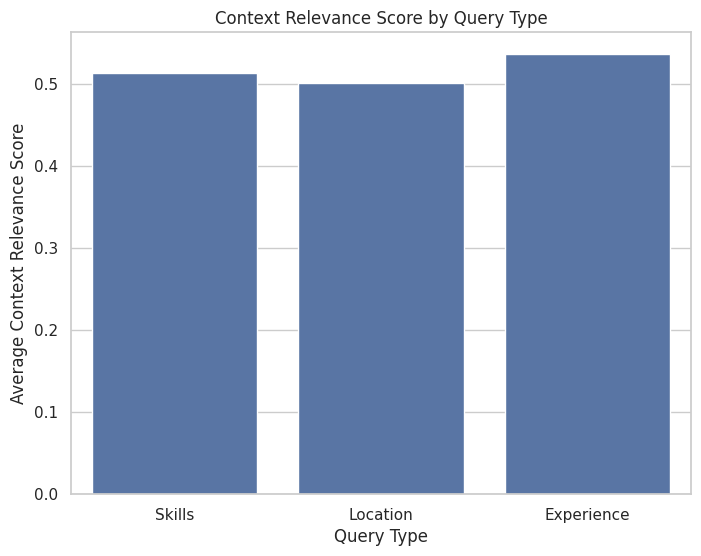

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=performance_df.index, y='Context Relevance', data=performance_df.reset_index())
plt.title('Context Relevance Score by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Average Context Relevance Score')
plt.show()

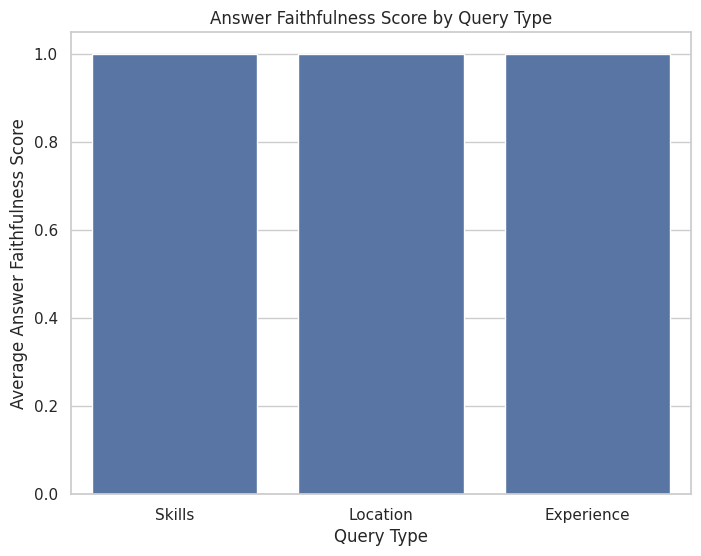

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=performance_df.index, y='Answer Faithfulness', data=performance_df.reset_index())
plt.title('Answer Faithfulness Score by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Average Answer Faithfulness Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


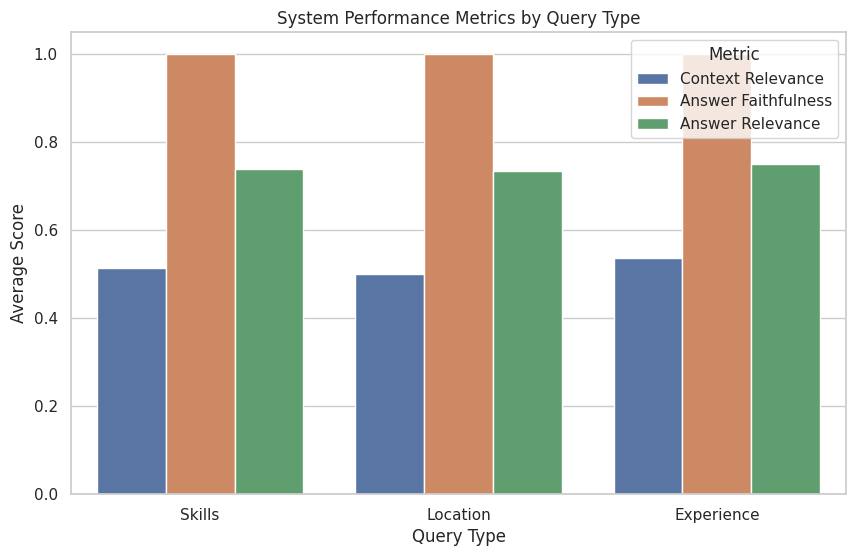

In [ ]:
# Melt the DataFrame to long format
performance_long_df = performance_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
performance_long_df.rename(columns={'index': 'Query Type'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Query Type', y='Score', hue='Metric', data=performance_long_df)
plt.title('System Performance Metrics by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Average Score')
plt.legend(title='Metric')
plt.show()

# Phase 4

Query handling and speed

In [ ]:
# Initialize dictionaries to store timing

timing_metrics = defaultdict(list)

# Loop over each query type
for query_type in ['Skills', 'Location', 'Experience']:
    # Get resumes for the current query type
    resumes_subset = exploded_df[exploded_df['Categories'] == query_type]

    query_times = []

    # Loop through the unique resumes for this category
    for idx in tqdm(resumes_subset['Resume_Index'].unique(), desc=f'Evaluating {query_type} Queries'):
        resume_text = df_test.iloc[idx]['Resume']
        resume_embedding = test_resume_embeddings_normalized[idx]

        # Skip resumes with zero embeddings if necessary
        if np.all(resume_embedding == 0):
            continue

        # Measure time taken to retrieve jobs and evaluate
        start_time = time.time()

        # Retrieve jobs based on resume embedding
        retrieved_jobs = retrieve_jobs(resume_embedding, top_n=5)

        if retrieved_jobs.empty:
            continue

        # Record the time taken
        elapsed_time = time.time() - start_time
        query_times.append(elapsed_time)

    # Store the average time taken for the current query type
    timing_metrics[query_type] = {
        'Average Time (s)': np.mean(query_times) if query_times else 0,
        'Max Time (s)': np.max(query_times) if query_times else 0,
        'Min Time (s)': np.min(query_times) if query_times else 0
    }

    # Display system speed results
    print("\nSystem Speed Metrics:")
    for query_type, time_metrics in timing_metrics.items():
        print(f"\nSpeed metrics for {query_type} queries:")
        print(f"Average Time: {time_metrics['Average Time (s)']:.4f} seconds")
        print(f"Max Time: {time_metrics['Max Time (s)']:.4f} seconds")
        print(f"Min Time: {time_metrics['Min Time (s)']:.4f} seconds")

Evaluating Skills Queries:   0%|          | 0/57 [00:00<?, ?it/s]


System Speed Metrics:

Speed metrics for Skills queries:
Average Time: 0.0158 seconds
Max Time: 0.0356 seconds
Min Time: 0.0089 seconds


Evaluating Location Queries:   0%|          | 0/38 [00:00<?, ?it/s]


System Speed Metrics:

Speed metrics for Skills queries:
Average Time: 0.0158 seconds
Max Time: 0.0356 seconds
Min Time: 0.0089 seconds

Speed metrics for Location queries:
Average Time: 0.0093 seconds
Max Time: 0.0171 seconds
Min Time: 0.0064 seconds


Evaluating Experience Queries:   0%|          | 0/7 [00:00<?, ?it/s]


System Speed Metrics:

Speed metrics for Skills queries:
Average Time: 0.0158 seconds
Max Time: 0.0356 seconds
Min Time: 0.0089 seconds

Speed metrics for Location queries:
Average Time: 0.0093 seconds
Max Time: 0.0171 seconds
Min Time: 0.0064 seconds

Speed metrics for Experience queries:
Average Time: 0.0079 seconds
Max Time: 0.0129 seconds
Min Time: 0.0068 seconds


## Phase 5

In [ ]:
def compute_bleu(reference, candidate):
    """
    Compute BLEU score between reference and candidate texts.
    """
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    smoothie = SmoothingFunction().method4
    score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)
    return score

def compute_meteor(reference, candidate):
    """
    Compute METEOR score between reference and candidate texts.
    """
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    score = single_meteor_score(reference_tokens, candidate_tokens)
    return score

def compute_rouge(reference, candidate):
    """
    Compute ROUGE scores between reference and candidate texts.
    Returns a dictionary with ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference.lower(), candidate.lower())
    return {
        'ROUGE-1': scores['rouge1'].fmeasure,
        'ROUGE-2': scores['rouge2'].fmeasure,
        'ROUGE-L': scores['rougeL'].fmeasure
    }

In [ ]:
def compute_relevance(retrieved_jobs):
    """
    Compute the average similarity score as a measure of relevance.

    Parameters:
    - retrieved_jobs: DataFrame of retrieved jobs with 'similarity_score'.

    Returns:
    - Average similarity score.
    """
    if retrieved_jobs.empty:
        return 0
    return retrieved_jobs['similarity_score'].mean()

In [ ]:
def measure_retrieval_speed(resume_embedding, top_n=5):
    """
    Measure the time taken to retrieve jobs for a given resume embedding.

    Parameters:
    - resume_embedding: Numpy array of the resume's embedding.
    - top_n: Number of top jobs to retrieve.

    Returns:
    - Retrieved jobs DataFrame.
    - Retrieval time in seconds.
    """
    start_time = time.time()
    retrieved_jobs = retrieve_jobs(resume_embedding, top_n=top_n)
    end_time = time.time()
    retrieval_time = end_time - start_time
    return retrieved_jobs, retrieval_time

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# Initialize performance metrics dictionary
performance_metrics = defaultdict(lambda: {
    'Context Relevance': [],
    'Answer Faithfulness': [],
    'Answer Relevance': [],
    'BLEU': [],
    'ROUGE-1': [],
    'ROUGE-2': [],
    'ROUGE-L': [],
    'METEOR': [],
    'Retrieval Speed (s)': []
})

# Define the query types to evaluate, including 'Other' if applicable
query_types = ['Skills', 'Location', 'Experience', 'Other']

for query_type in tqdm(query_types, desc='Evaluating Query Types'):
    # Get resumes for the current query type
    resumes_subset = df_test_with_categories[df_test_with_categories['Categories'].apply(lambda x: query_type in x)]

    # Initialize lists to store metrics for the current query type
    context_relevance_scores = []
    answer_faithfulness_scores = []
    answer_relevance_scores = []
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    meteor_scores = []
    retrieval_speeds = []

    for idx in tqdm(resumes_subset.index, desc=f'Evaluating {query_type} Queries', leave=False):
        resume_text = df_test_with_categories.loc[idx, 'Resume']
        resume_embedding = test_resume_embeddings_normalized[idx]
        reference_job_desc = df_test_with_categories.loc[idx, 'Full-Job-Description']
        reference_job_id = df_test_with_categories.loc[idx, 'Job_ID']

        # Skip resumes with zero embeddings
        if np.all(resume_embedding == 0):
            continue

        # Measure retrieval speed and retrieve jobs
        retrieved_jobs, retrieval_time = measure_retrieval_speed(resume_embedding, top_n=5)

        if retrieved_jobs.empty:
            continue

        # Evaluate Context Relevance
        context_scores = []
        for _, job in retrieved_jobs.iterrows():
            job_text = job['Full-Job-Description']
            context_relevance_score, _ = evaluate_context_relevance(resume_text, job_text)
            context_scores.append(context_relevance_score)
        # Average context relevance score
        avg_context_relevance = np.mean(context_scores)
        context_relevance_scores.append(avg_context_relevance)

        # Evaluate Answer Faithfulness
        faithfulness_score = evaluate_answer_faithfulness(retrieved_jobs, df_train)
        answer_faithfulness_scores.append(faithfulness_score)

        # Evaluate Answer Relevance
        answer_relevance_scores_per_resume = []
        for _, job in retrieved_jobs.iterrows():
            job_text = job['Full-Job-Description']
            context_relevance_score, _ = evaluate_context_relevance(resume_text, job_text)
            similarity_score = job['similarity_score']
            # Normalize similarity score if necessary (assuming cosine similarity from -1 to 1)
            normalized_similarity_score = (similarity_score + 1) / 2
            answer_relevance_score = compute_answer_relevance(normalized_similarity_score, context_relevance_score)
            answer_relevance_scores_per_resume.append(answer_relevance_score)
        # Average answer relevance score
        avg_answer_relevance = np.mean(answer_relevance_scores_per_resume)
        answer_relevance_scores.append(avg_answer_relevance)

        # Compute BLEU, ROUGE, METEOR
        for _, job in retrieved_jobs.iterrows():
            candidate = job['Full-Job-Description']
            reference = reference_job_desc
            bleu = compute_bleu(reference, candidate)
            meteor = compute_meteor(reference, candidate)
            rouge_scores = compute_rouge(reference, candidate)
            bleu_scores.append(bleu)
            meteor_scores.append(meteor)
            rouge1_scores.append(rouge_scores['ROUGE-1'])
            rouge2_scores.append(rouge_scores['ROUGE-2'])
            rougeL_scores.append(rouge_scores['ROUGE-L'])

        # Record Retrieval Speed
        retrieval_speeds.append(retrieval_time)

    # Store the average metrics for the current query type
    performance_metrics[query_type] = {
        'Context Relevance': np.mean(context_relevance_scores) if context_relevance_scores else 0,
        'Answer Faithfulness': np.mean(answer_faithfulness_scores) if answer_faithfulness_scores else 0,
        'Answer Relevance': np.mean(answer_relevance_scores) if answer_relevance_scores else 0,
        'BLEU': np.mean(bleu_scores) if bleu_scores else 0,
        'ROUGE-1': np.mean(rouge1_scores) if rouge1_scores else 0,
        'ROUGE-2': np.mean(rouge2_scores) if rouge2_scores else 0,
        'ROUGE-L': np.mean(rougeL_scores) if rougeL_scores else 0,
        'METEOR': np.mean(meteor_scores) if meteor_scores else 0,
        'Retrieval Speed (s)': np.mean(retrieval_speeds) if retrieval_speeds else 0
    }

# Compile performance metrics into a DataFrame
performance_summary = {}
for query_type, metrics in performance_metrics.items():
    performance_summary[query_type] = {
        'Context Relevance': metrics['Context Relevance'],
        'Answer Faithfulness': metrics['Answer Faithfulness'],
        'Answer Relevance': metrics['Answer Relevance'],
        'BLEU': metrics['BLEU'],
        'ROUGE-1': metrics['ROUGE-1'],
        'ROUGE-2': metrics['ROUGE-2'],
        'ROUGE-L': metrics['ROUGE-L'],
        'METEOR': metrics['METEOR'],
        'Retrieval Speed (s)': metrics['Retrieval Speed (s)']
    }

performance_df = pd.DataFrame.from_dict(performance_summary, orient='index').reset_index()
performance_df = performance_df.rename(columns={'index': 'Query Type'})

# Display the performance DataFrame
print(performance_df)

Evaluating Skills Queries:   0%|          | 0/57 [00:00<?, ?it/s]

TypeError: "reference" expects pre-tokenized reference (Iterable[str]): innovative

In [ ]:
# Set Seaborn style for better aesthetics
sns.set(style='whitegrid')

# 4.1. Separate Bar Charts for Each Metric

metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Query Type', y=metric, data=performance_df)
    plt.title(f'{metric} Score by Query Type')
    plt.xlabel('Query Type')
    plt.ylabel(f'Average {metric} Score')
    plt.ylim(0, 1)  # Assuming all metrics are normalized between 0 and 1
    plt.show()

# 4.2. Combined Bar Chart for All Metrics

# Melt the DataFrame to long format for easier plotting
performance_long_df = performance_df.melt(id_vars='Query Type',
                                         value_vars=['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR'],
                                         var_name='Metric',
                                         value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Query Type', y='Score', hue='Metric', data=performance_long_df)
plt.title('System Performance Metrics by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Average Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()

# 4.3. Scatter Plot: BLEU vs. ROUGE-1

plt.figure(figsize=(10, 6))
sns.scatterplot(data=performance_df, x='BLEU', y='ROUGE-1', hue='Query Type', s=100)
plt.title('BLEU vs ROUGE-1 Scores by Query Type')
plt.xlabel('BLEU Score')
plt.ylabel('ROUGE-1 Score')
plt.legend(title='Query Type')
plt.show()

# 4.4. Line Graph: Retrieval Speed Across Query Types

plt.figure(figsize=(10, 6))
sns.lineplot(x='Query Type', y='Retrieval Speed (s)', data=performance_df, marker='o')
plt.title('Retrieval Speed by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Average Retrieval Speed (seconds)')
plt.ylim(0, performance_df['Retrieval Speed (s)'].max() + 1)
plt.show()

# 4.5. Heatmap of Performance Metrics

# Select metrics to include in the heatmap
heatmap_data = performance_df.set_index('Query Type')[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR']]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Heatmap of System Performance Metrics by Query Type')
plt.xlabel('Metric')
plt.ylabel('Query Type')
plt.show()